# Votes and Taxation by State, the 2016 US Presidential Election
## D Bolta <br>Jan, 2019

Uses data from the IRS combined with 2016 voting results, let's see if there's any patterns between how much money a state gives/gets from the US treasury vs. political leanings.

In [1]:
# Load libraries
# Function wrapper to suppress startup warnings and messages
library_no_messages_or_warnings = function(xxx){
  suppressMessages(suppressWarnings(xxx))  
}

## Install new package
#install.packages("e1071", repos ="https://cloud.r-project.org/")

# Tidyverse and modeling support
library_no_messages_or_warnings(library(dplyr))
library_no_messages_or_warnings(library(Metrics))
library_no_messages_or_warnings(library(caret))
library_no_messages_or_warnings(library(e1071))

# Graphing support
library_no_messages_or_warnings(library(ggplot2))
library_no_messages_or_warnings(library(gridExtra))
library_no_messages_or_warnings(library(corrplot))
library_no_messages_or_warnings(library(rpart.plot))
library_no_messages_or_warnings(library(rattle))
library_no_messages_or_warnings(library(RColorBrewer))
library_no_messages_or_warnings(library(rpart))

### Lets read in the data and start data prep.
Grab the column names, first.

In [29]:
data_1 = read.csv("data_1.csv",
                  stringsAsFactors = FALSE) %>%
  na.omit()
names(data_1) %>%
  as.data.frame(stringgsAsFactors = FALSE)

.
State
Corp_tax_as_perc_of_total
Individual_tax_as_perc_of_total
Taxes_paid
Fed_subsidies
Pop_2017
Tax_per_capita
Tax_minus_subsidy_per_capita
DJT_vote_perc_2016
Residual_vote_perc


### Data explanation
-State (row label)
<br>-Tax source: corporate/individual
<br>-Taxes in/subsidies out of treasury
<br>-State populations
<br>-Per capita taxes, net treasury cash flow
<br>-Vote breakdowns

#### Check the data quickly, just to make sure things are reading in properly (that percents, strings, dates, etc. aren't creating problems)

In [3]:
head(data_1)

State,Corp_tax_as_perc_of_total,Individual_tax_as_perc_of_total,Taxes_paid,Fed_subsidies,Pop_2017,Tax_per_capita,Tax_minus_subsidy_per_capita,DJT_vote_perc_2016,Residual_vote_perc,DJT_WIN
Alabama,0.06015562,0.9249305,26583916,66190000,4874747,5453.394,-8124.7466,0.63,0.02,1
Alaska,0.03218699,0.9559736,5399946,8570000,739795,7299.246,-4285.0438,0.53,0.09,1
Arizona,0.07394090,0.8904450,43928177,74300000,7016270,6260.902,-4328.7706,0.50,0.05,1
Arkansas,0.15550243,0.8199078,32458328,23167000,3004279,10804.033,3092.6981,0.60,0.06,1
Florida,0.04696066,0.9332448,192869033,177103000,20984400,9191.067,751.3216,0.49,0.03,1
Georgia,0.13559881,0.8226765,94277375,62347000,10429379,9039.596,3061.5797,0.51,0.03,1


### Scrub cocorrelated variables using caret.
Since correlation requires continuous/numeric variables, I'll drop the state labels before processing.

In [4]:
# Identify variables with >0.9 correlation within the data.
highlyCorDescr = data_1 %>%
  select(-State) %>%
  cor() %>%
  findCorrelation(cutoff = 0.9)

tmp = data_1 %>%
  select(-State) %>%
  names()
tmp[highlyCorDescr]
rm(tmp)

[1] "Taxes_paid"                "Pop_2017"                 
[3] "Corp_tax_as_perc_of_total"

There are a few corrleations due to the feature transformations (normalization on the per capita columns, etc.).
<br>I'll just keep everything for now.

#### Let's also do a quick check for linear redundancy (to ensure the data is full rank).
Although the data is similar, it doesn't make sense to keep fully redundant information.

In [5]:
findLinearCombos(data_1 %>%
                   select(-State))

$linearCombos
list()

$remove
NULL

#### Caret found nothing to remove.
Note- if I had included columns that were just differences of each other (e.g. DJT_vote, HRC_vote, and DJT_margin_over_HRC), this is where they would be flagged as redundant. 

### Let's look at how the data correlate to each state's voting record.
I'll create a correlation matrix, filter down to the target variable, then sort by the correlation level. 
<br>Correlation ranges -1:1, so I'll sort by the absolute value of correlation, but include the original column side-by-side. 

In [6]:
cor_mat = data_1 %>%
  select(-State) %>%
  cor() %>%
  as.data.frame() %>%
  mutate(names = row.names(.),
         abs_DJT_vote_perc_2016 = abs(DJT_vote_perc_2016))

cor_mat %>%
  select(names, DJT_vote_perc_2016, abs_DJT_vote_perc_2016) %>%
  arrange(desc(abs_DJT_vote_perc_2016))

Warning message:
"package 'bindrcpp' was built under R version 3.4.3"

names,DJT_vote_perc_2016,abs_DJT_vote_perc_2016
DJT_vote_perc_2016,1.000000000,1.000000000
DJT_WIN,0.771151785,0.771151785
Tax_per_capita,-0.633723471,0.633723471
Taxes_paid,-0.268764816,0.268764816
Tax_minus_subsidy_per_capita,-0.233083692,0.233083692
Pop_2017,-0.174344325,0.174344325
Fed_subsidies,-0.141788410,0.141788410
Corp_tax_as_perc_of_total,-0.112539873,0.112539873
Individual_tax_as_perc_of_total,-0.012701725,0.012701725
Residual_vote_perc,-0.003260276,0.003260276


### So the main correlator to states voting Trump is how much taxes they paid.
More taxes per person (or state), more HRC votes. 

## Now, lets try some visual analytics

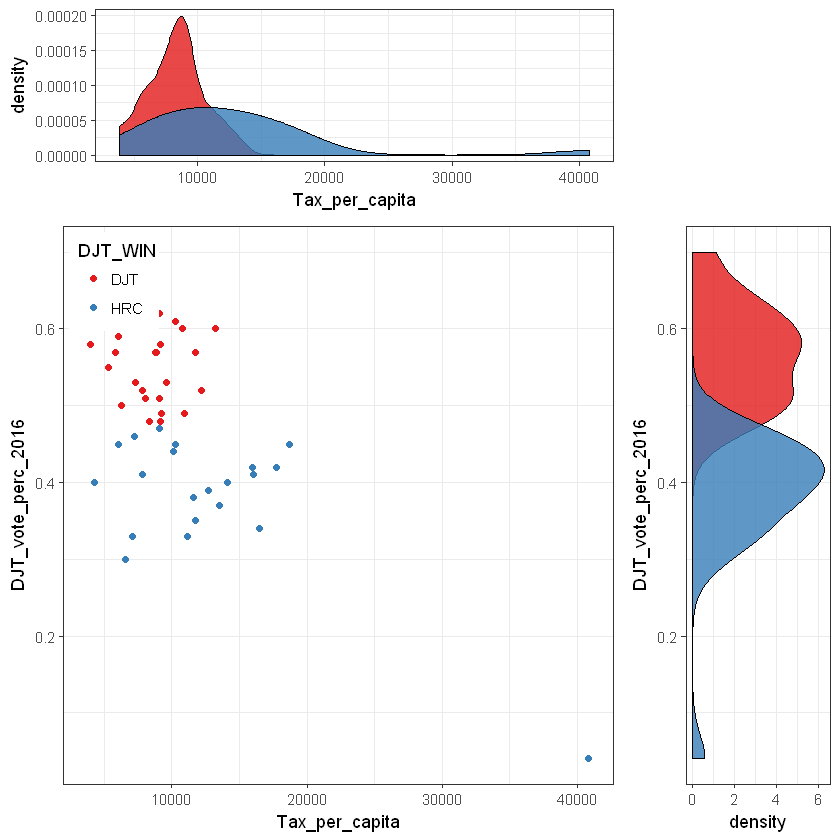

In [7]:
data_1_graph = data_1 %>%
  mutate(DJT_WIN = ifelse(DJT_WIN == 1, "DJT", "HRC"))

scatterPlot = data_1_graph %>%
  ggplot(aes(Tax_per_capita, DJT_vote_perc_2016)) + 
  geom_point(aes(color = DJT_WIN)) + 
  scale_color_brewer(palette="Set1") + 
  theme_bw() +
  theme(legend.position=c(0.01, 0.99), legend.justification=c(0,1)) 

# Marginal density plot of x (top panel) 
xdensity = data_1_graph %>%
  ggplot(aes(Tax_per_capita)) + 
  geom_density(aes(fill = DJT_WIN), alpha= 0.8) + 
  scale_fill_brewer(palette="Set1") +
  theme_bw() +
  theme(legend.position = "none") 

# Marginal density plot of y (right panel) 
ydensity = data_1_graph %>%
  ggplot(aes(DJT_vote_perc_2016)) + 
  geom_density(aes(fill = DJT_WIN), alpha= 0.8) + 
  scale_fill_brewer(palette="Set1") +
  theme_bw() +
  theme(legend.position = "none") + 
  coord_flip()

blankPlot = ggplot() + geom_blank() + theme_void()

grid.arrange(xdensity, blankPlot, scatterPlot, ydensity, ncol=2, nrow=2, widths=c(4, 1.4), heights=c(1.4, 4)) 

## Conclusions from the graph "DJT vote percent vs. Population, colored by State Winner"
### 1. The coloring: How is Trump winning in states where he received less than 50% votes?
Why doesn't the color break right at 50%? Is something wrong with the data?
<br> Trump manages to win in 5 states where he receives less than 50% of the vote because others (e.g. Bernie Sanders) took votes away from Hillary.
### 2. What about that Most-correlated variable?
Above, we saw that taxes paid per capita was the strongest (negative) correlator to the concentration of Trump votes.
<br>The graph suggests that this effect is mostly driven by the leverage of one outlier state.
<br>Lets view the data and check on the outlier.

In [8]:
data_1_graph %>%
  select(State, Tax_per_capita, DJT_vote_perc_2016, DJT_WIN) %>%
  arrange(desc(Tax_per_capita)) %>%
  slice(1:11)

State,Tax_per_capita,DJT_vote_perc_2016,DJT_WIN
District of Columbia,40784.00,0.04,HRC
Minnesota,18726.37,0.45,HRC
Delaware,17757.21,0.42,HRC
Massachusetts,16472.20,0.34,HRC
Connecticut,16036.04,0.41,HRC
New Jersey,15971.70,0.42,HRC
Rhode Island,14077.87,0.40,HRC
New York,13519.49,0.37,HRC
Nebraska,13254.68,0.60,DJT
Illinois,12679.75,0.39,HRC


#### The outlier state is not even a state.
However, after slicing out the top 10 states (and viewing the graph), we can see that only 2 of the top 10 most highly taxed state poulations went for Trump.
<br>Although correlation is a linear trend, and susceptible to many issues, there is indeed a pattern of high federally-taxed states going for Hillary.

## Explore the data with a classification tree
First, lets build the tree

In [9]:
data_2 = data_1 %>%
  select(-State, -DJT_vote_perc_2016) %>%
  mutate(DJT_WIN = ifelse(DJT_WIN == 1, "DJT", "HRC"))

tree_model = rpart(DJT_WIN ~ ., 
                   data = data_2, 
                   method = "class", 
                   minsplit = 2, 
                   minbucket = 1, 
                   parms = list(split = 'information'))

#### First, extract the variable importances.

In [10]:
tree_model$variable.importance %>%
  as.data.frame()

,.
Tax_per_capita,17.652413
Corp_tax_as_perc_of_total,13.372178
Individual_tax_as_perc_of_total,10.505285
Tax_minus_subsidy_per_capita,9.971320
Taxes_paid,7.409455
Pop_2017,5.283023
Residual_vote_perc,3.649918
Fed_subsidies,1.643715


#### Qualitatively, resluts are very similar to the linear correlations.
<br>Taxes are very important, but now the tax breakouts of corporate vs. individual are much more important.
<br>This change may be because the percentages are assumed to be continuous and range infinitely for linear. Decision trees make no such assumption.
<br>I could have rescaled the percentages using some kind of hyperbolic or inv_tan functional shape, but not worth catering to the linear model assumptions for this exercise. 

#### Lets introspect the tree decision points. 
(Thanks to the rattle package.)

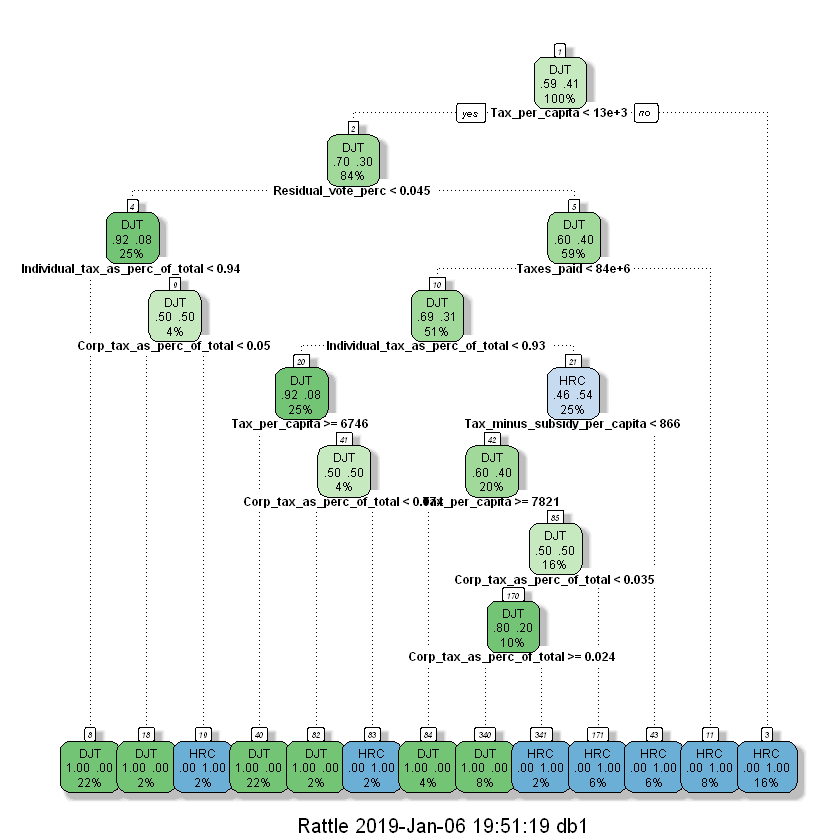

In [11]:
fancyRpartPlot(tree_model, cex = 0.6, box.palette = c("red", "blue"), pal.thresh = 0.5)

#### Once again, the top split is on taxes per capita.
This is a nice validation of the linear correlation exercise.
<br>The second branch suggests that the third party vote actually hurt Trump (after the tax impact is removed).
<br>Almost all the other nodes with any amount of data are associated with some type of tax.

#### More visual analytics. Lets review impacts vs. net cash flow to the state. 
We can look at interactions of 2 variables by cross-plotting and then coloring by the target variable.

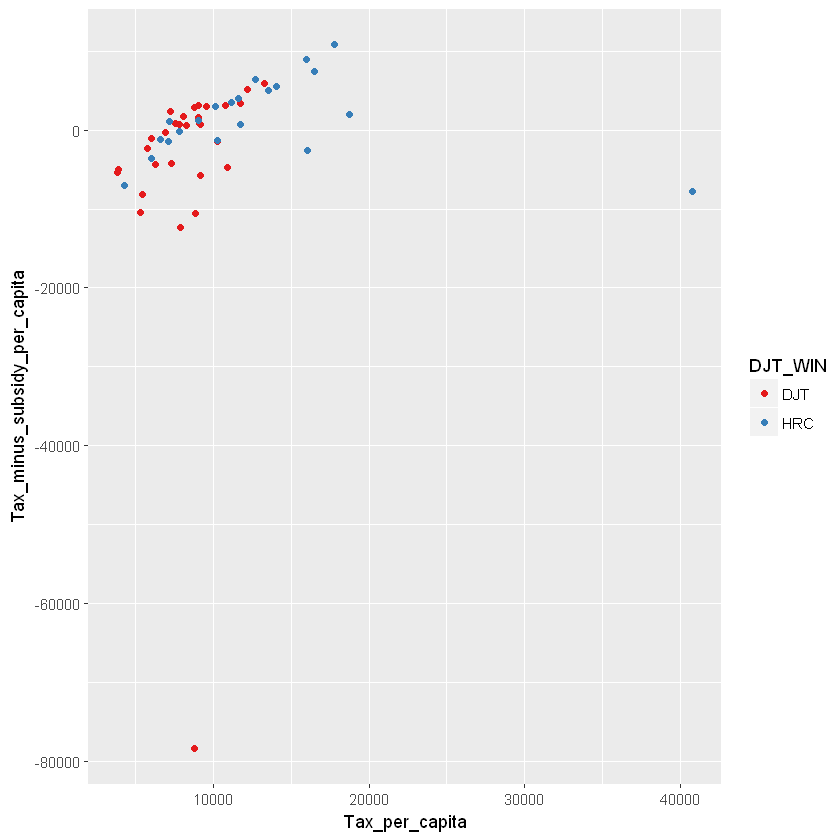

In [12]:
data_2 %>%
  ggplot(aes(Tax_per_capita, Tax_minus_subsidy_per_capita)) +
  geom_point(aes(color = DJT_WIN)) + 
  scale_color_brewer(palette="Set1")

Hmm, looks like there's a red state getting a large federal subsidy.
<br>Let's just check the data.

In [13]:
data_1 %>%
  arrange(Tax_minus_subsidy_per_capita) %>%
  select(State, DJT_WIN, Tax_minus_subsidy_per_capita) %>%
  head()

State,DJT_WIN,Tax_minus_subsidy_per_capita
North Dakota,1,-78406.513
Kentucky,1,-12375.564
Indiana,1,-10515.963
South Carolina,1,-10389.550
Alabama,1,-8124.747
District of Columbia,0,-7762.629


It looks like North Dakota is receiving a ton of money and paying very little taxes per capita.
<br>Also, the 5 states receiving the most subsidy per capita all voted for Trump.
<br>There's plenty of arguments here. I'm not a political analyst, so I'll just touch on the first that comes to mind for both side:
<br>-This runs counter to the psychology of conservative fiscal policy. These states might have the most to risk if the federal government were to cut taxes & subsidies.
<br>-However, perhaps these states also see the need for upheaval. They are receiving aide; it's not helping. Trump could be the outside candidate to come in and drain the swamp. 

#### Looking back at the scatterplot
There also seems to be an interesting linear pattern acting as a ceiling. The more taxes paid, the more taxes_minus_subsidies paid.
<br>This is probably an artificial construct manifested by the actual policy codified into law.

#### What about population's impact?

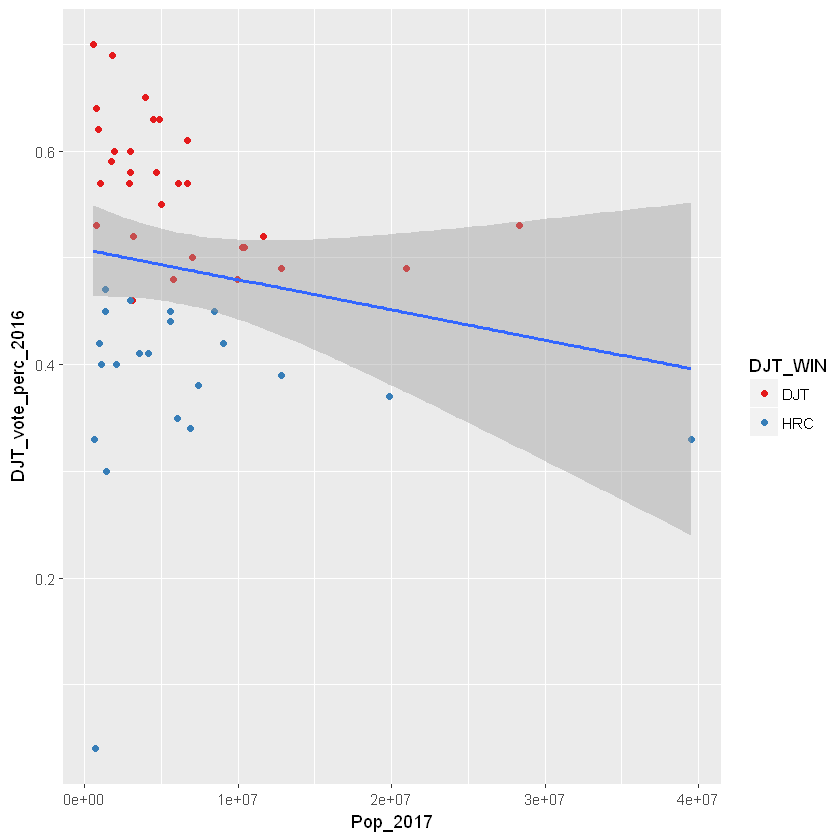

In [35]:
data_1 %>%
  mutate(DJT_WIN = ifelse(DJT_WIN == 1, "DJT", "HRC")) %>%
  ggplot(aes(Pop_2017, DJT_vote_perc_2016)) +
  geom_point(aes(color = DJT_WIN)) + 
  geom_smooth(method='lm',formula=y~x) +
  scale_color_brewer(palette="Set1")

Many people thing of large states voting democrat and small, farm states voting democrat.
<br>There is a general, linear trend in this direction. But in fact that stereotype is probably more associated with population density.
<br>There are some large states which are staunchly conservative (Texas), and many small states (both by population and land area) in the northeast that vote liberal.

### Lets create a quick linear model.
R makes it so easy, why not

First, the data looks quite skewed, so check for BoxCox reshaping (to help normalize skewed data with power transforms).
<br>Also run the standard center & scale operation for linear regression.

In [36]:
data_3a_for_caret = data_1 %>%
  select(-State, -DJT_WIN) 

boxcoxValues = preProcess(data_3a_for_caret, method = "BoxCox")
data_3b_boxcox = predict(boxcoxValues, data_3a_for_caret)
centers_scales = data_3b_boxcox %>%
  preProcess(method = c("center", "scale"))
data_3c_scaled = predict(centers_scales, data_3b_boxcox)

Check the target variable to see if caret recommends any power transformation.

In [37]:
boxcoxValues$bc$DJT_vote_percent_2016

NULL

Lets use caret's recursive feature elimination (backwards-stepping wrapper function), to remove less predictive variables.
<br>We'll use caret's default fold count (10) over 5 repeats.
<br>Repeated CV can be quite slow. Since these are linear models, speed should be fine.
<br><br>Another note- With information leak, CV won't be terribly useful; it will just tune to the most overfit solution set.
<br>https://www.rdocumentation.org/packages/caret/versions/6.0-81/topics/rfeControl

In [38]:
set.seed(12345)
lm_rfe = rfe(DJT_vote_perc_2016 ~ .,
             data = data_3c_scaled,
             sizes = c(1:10),
             rfeControl = rfeControl(functions = lmFuncs,
                                     method = "repeatedcv",
                                     repeats = 5,
                                     verbose = FALSE,
                                     allowParallel = FALSE,
                                     seeds = NULL
                                    ))

Visualize the error through the backwards-stepping.

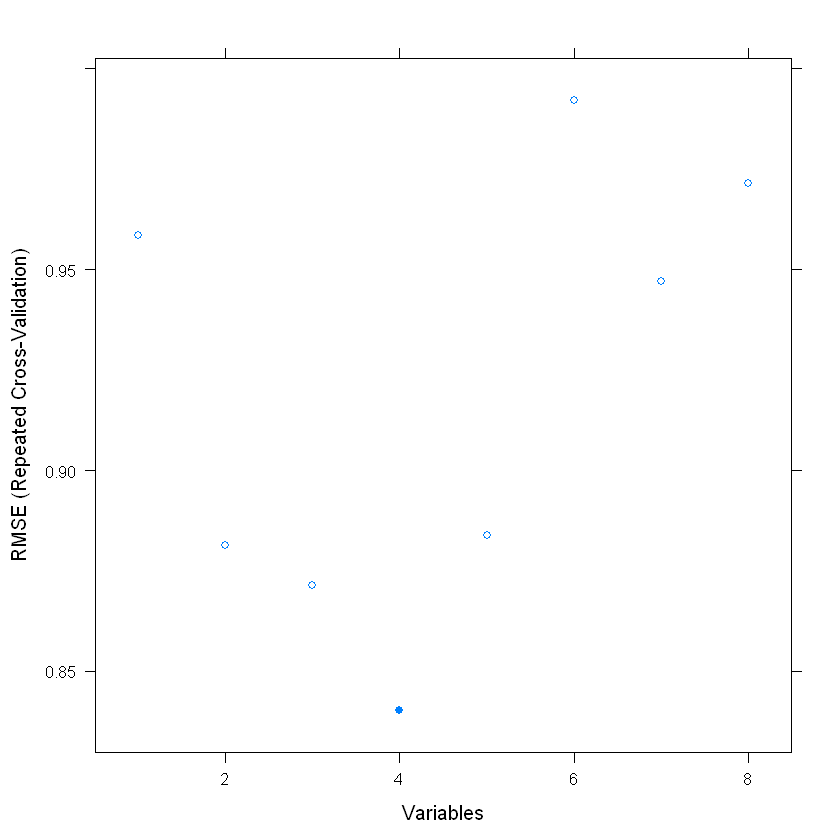

In [17]:
print(plot(lm_rfe))

Check the optimum variables associated with the min RMSE step.

In [18]:
lm_rfe$optVariables

[1] "Taxes_paid"                      "Pop_2017"                       
[3] "Tax_per_capita"                  "Individual_tax_as_perc_of_total"

#### Check stability by repeating with a couple different seeds.
Check out the documentation for seeds in rfeControl. Using the default value "NA" will not actually allow the set.seed call in the environment to have any effect. 
<br>In order to perturb the folds and test the stability of results across different seed starting points, 
<br>rfeControl(seeds = NULL)
<br>should be used.
<br>If the loop was occuring across multiple cores, the seeds would have to be listed out explicity (which we're not worrying about here).

[1] "Taxes_paid"     "Pop_2017"       "Tax_per_capita"

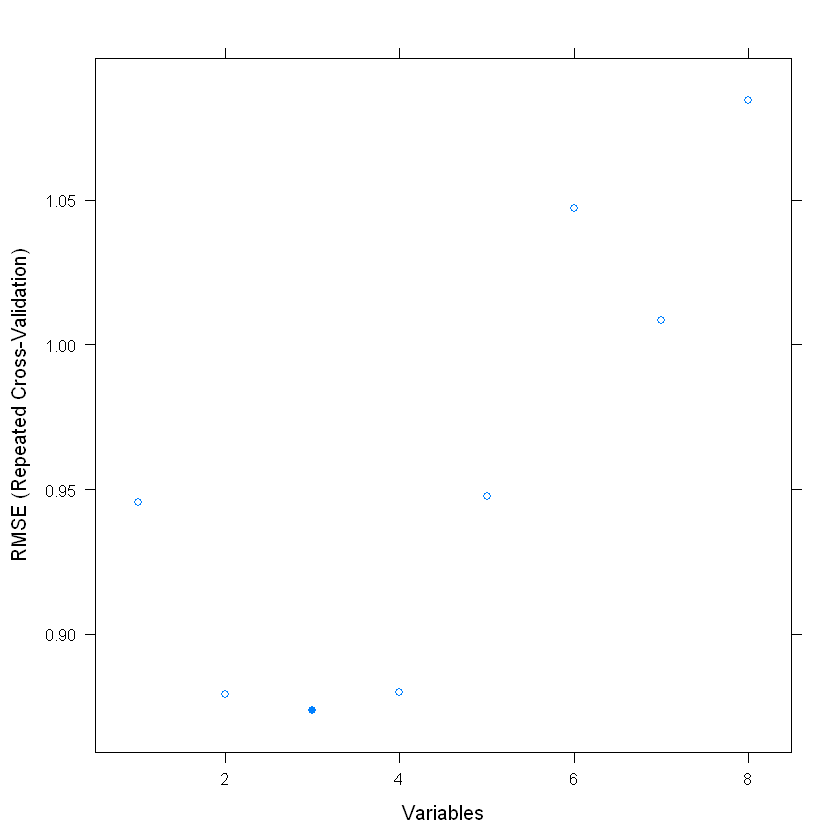

In [19]:
set.seed(5555)
lm_rfe = rfe(DJT_vote_perc_2016 ~ .,
             data = data_3c_scaled,
             sizes = c(1:10),
             rfeControl = rfeControl(functions = lmFuncs,
                                     method = "repeatedcv",
                                     repeats = 5,
                                     verbose = FALSE,
                                     allowParallel = FALSE,
                                     seeds = NULL))
print(plot(lm_rfe))
lm_rfe$optVariables

[1] "Taxes_paid"                      "Pop_2017"                       
[3] "Tax_per_capita"                  "Individual_tax_as_perc_of_total"

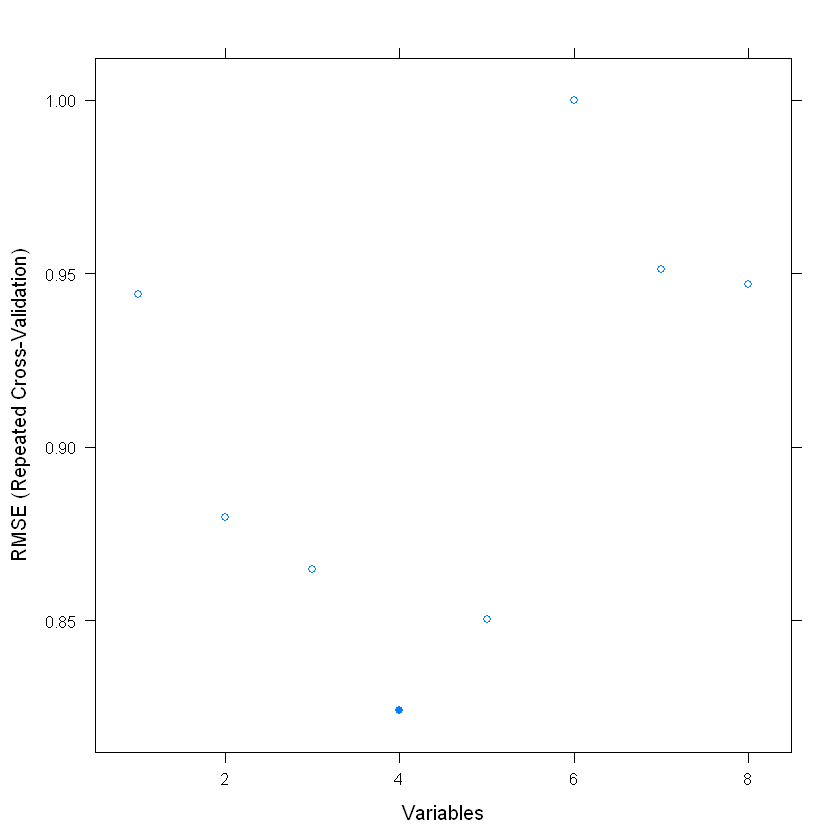

In [20]:
set.seed(34)
lm_rfe = rfe(DJT_vote_perc_2016 ~ .,
             data = data_3c_scaled,
             sizes = c(1:10),
             rfeControl = rfeControl(functions = lmFuncs,
                                     method = "repeatedcv",
                                     repeats = 5,
                                     verbose = FALSE,
                                     allowParallel = FALSE,
                                     seeds = NULL))
print(plot(lm_rfe))
lm_rfe$optVariables

### Cross validation results
The different runs settled at the same 3-4 variables and similar levels of RMSE.
<br>A nice aspect of RMSE is that it's the same units as the target variable.
<br>However, being off by 85-90% (on average!) is quite high in an election where Trump can only take 0-100% of the vote!

#### Lets use the rfe results to build the final model.

In [21]:
lm_model = paste0(lm_rfe$optVariables, collapse = " + ") %>%
  paste0("DJT_vote_perc_2016 ~ ", .) %>%
  as.formula() %>%
  lm(data = data_1)

Grab the model predictions
<br>Grab the normalized rmse
<br>Show the model summary

In [24]:
lm_predictions = predict(lm_model, data_1)
nrmse = rmse(actual = data_1$DJT_vote_perc_2016,
             predicted = lm_predictions) / mean(data_1$DJT_vote_perc_2016)
summary(lm_model)
paste0("NRMSE = ", nrmse)


Call:
lm(formula = ., data = data_1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.254167 -0.044796  0.004753  0.059977  0.169038 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      1.183e+00  2.237e-01   5.289 3.31e-06 ***
Taxes_paid                      -7.436e-10  8.023e-10  -0.927   0.3589    
Pop_2017                         4.906e-09  8.855e-09   0.554   0.5823    
Tax_per_capita                  -1.360e-05  2.814e-06  -4.831 1.54e-05 ***
Individual_tax_as_perc_of_total -6.015e-01  2.402e-01  -2.504   0.0159 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08797 on 46 degrees of freedom
Multiple R-squared:  0.4951,	Adjusted R-squared:  0.4512 
F-statistic: 11.28 on 4 and 46 DF,  p-value: 1.844e-06


[1] "NRMSE = 0.170569080459072"

#### Linear model summary results
Two of the variables don't pass a p < 0.05 threshold.
<br>The intercept has a very low p-value, suggesting that the available variables do not do a good job explaining the target response.
<br>The training R-squared and training NRMSE actually are not as terrible as the rfe CV results suggested, but the major difference is that the CV errors were from data NOT IN TRAIN. 
<br>This substantial difference in indicators between CV and train suggest this linear model may be overtrained (we could start trying to solve this by removing the variables with high P-values.)

#### Visualize linear model diagnostics
As part of R's catering to statisticians, calling 'plot' on a linear model object shows several diagnostics.

UVA has a pretty nice write up on the plots:
https://data.library.virginia.edu/diagnostic-plots/

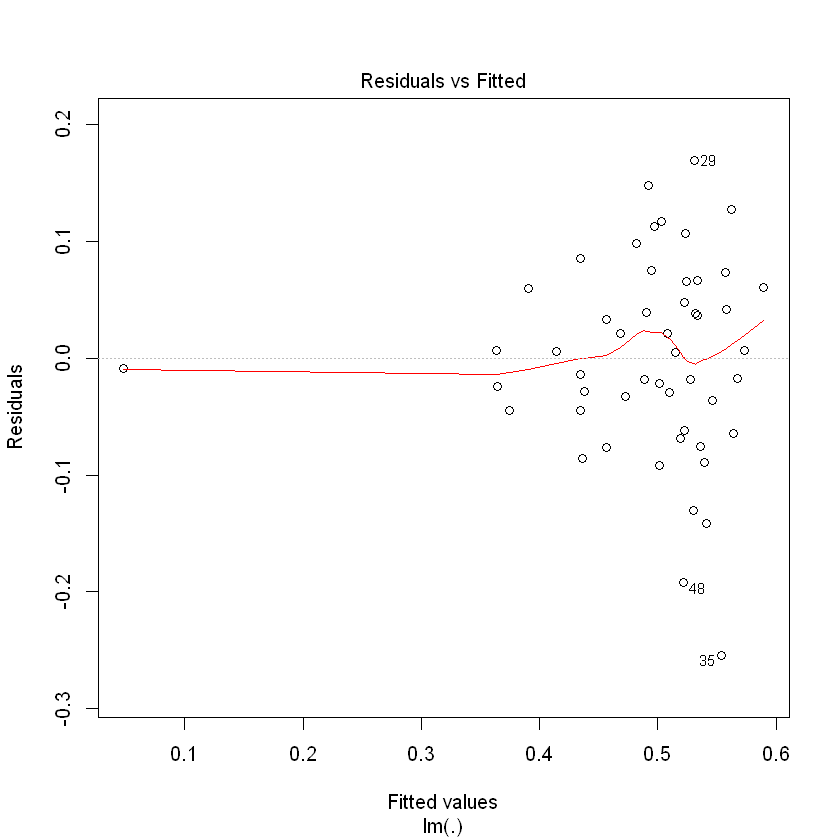

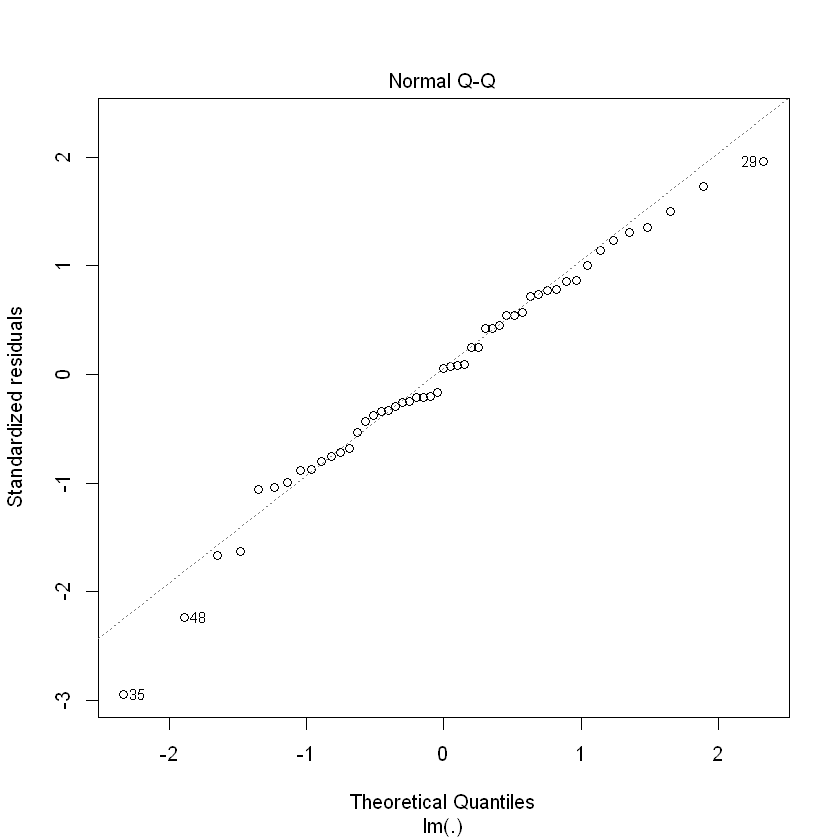

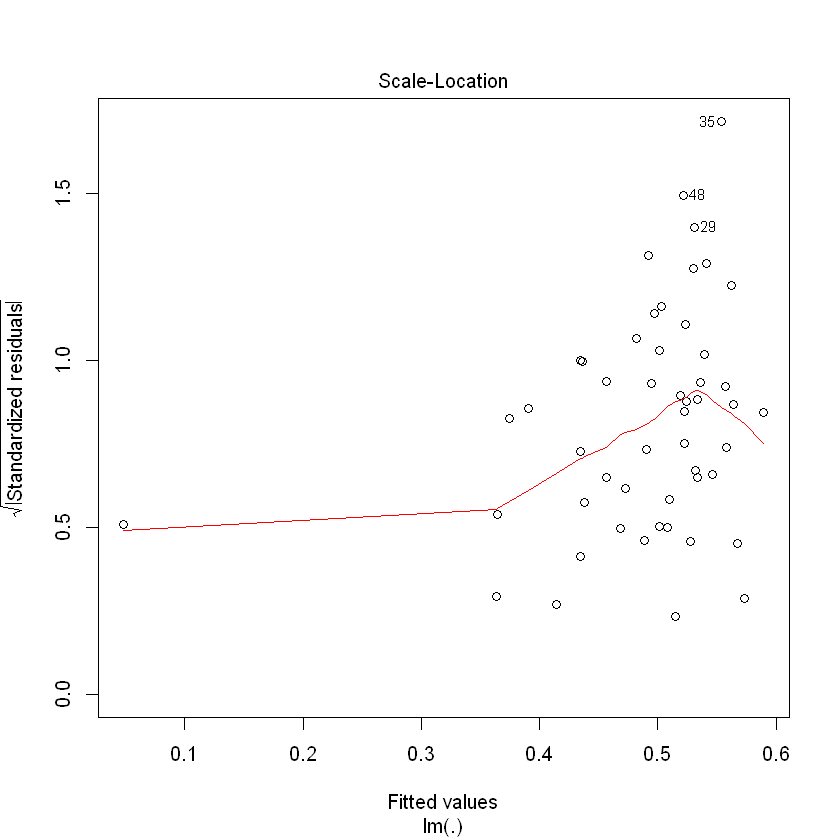

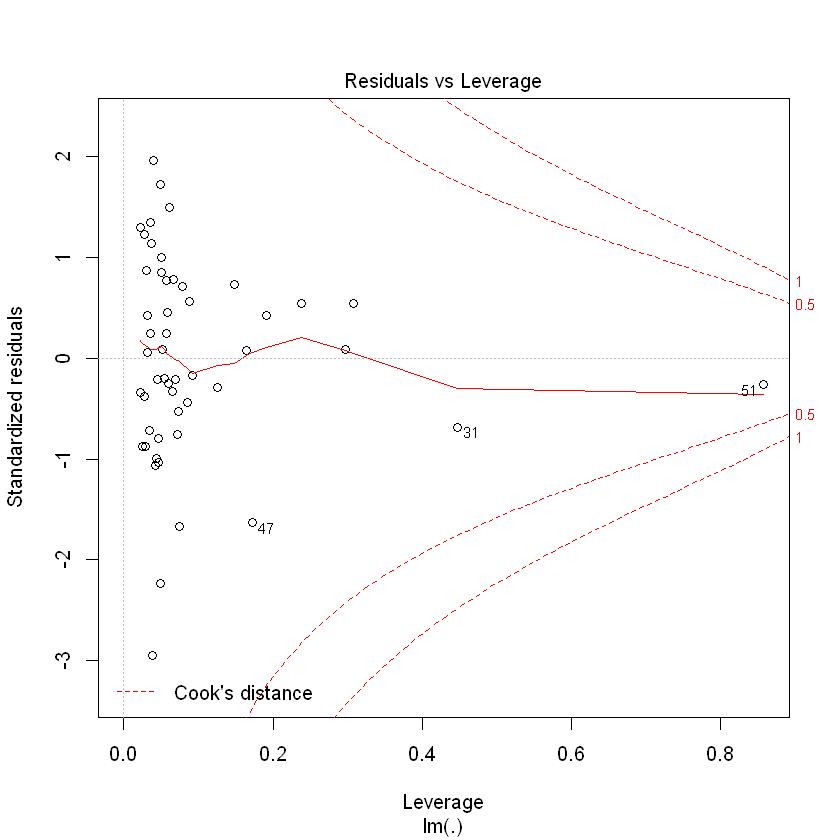

In [26]:
plot(lm_model)

 #### Plots results
 The residual plot does not look great. Residuals are quite widely spaced (poorly predicted)
 <br>The Q-Q plot does not suggest the data deviate too badly from the central limit theorem.
 <br>The cook's distance plot shows the outlier, but its not affecting the overall trend of the data.
 <br>Overall, the residuals are noisy i.e. poorly predicted.

#### Plot actual vs. predicted

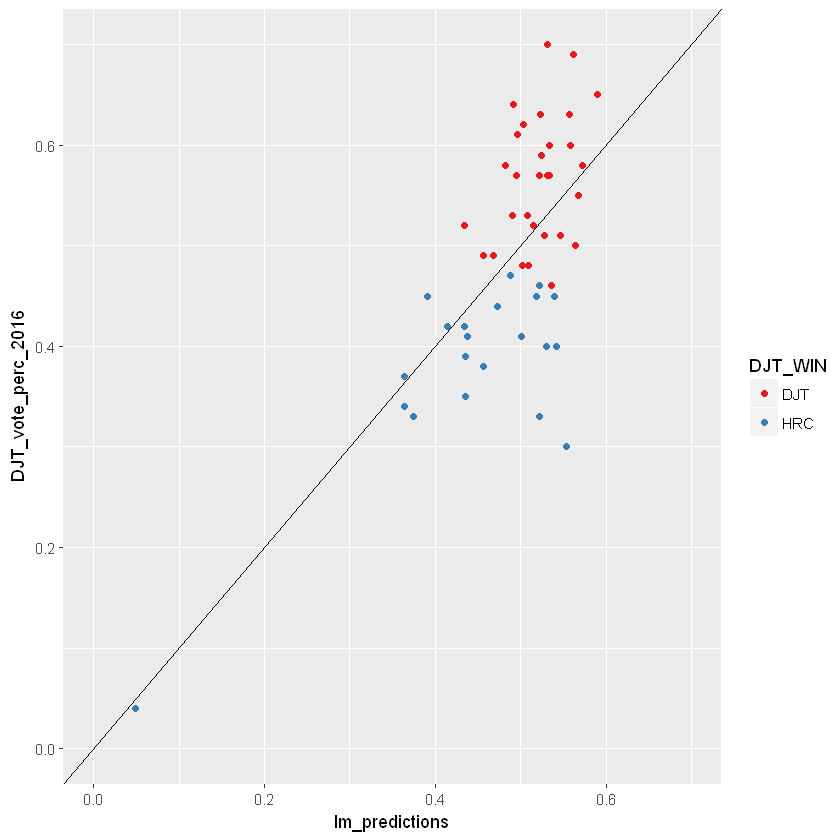

In [28]:
data_1 %>%
  mutate(DJT_WIN = ifelse(DJT_WIN == 1, "DJT", "HRC")) %>%
  ggplot(aes(lm_predictions, DJT_vote_perc_2016)) + 
  geom_point(aes(color = DJT_WIN)) +
  geom_abline(slope = 1, intercept = 0) +
  coord_cartesian(xlim = c(0, max(lm_predictions, data_1$DJT_vote_perc_2016)),
                  ylim = c(0, max(lm_predictions, data_1$DJT_vote_perc_2016))) +
  scale_color_brewer(palette="Set1")

#### Digesting AvP plot
Overall, noisy data. With just taxes and population data, there's not really enough here to predict vote results.

## Parting thoughts
Overall, the response of voter behavior to these indicators is very nonlinear, hence the decision tree doing a better job for uncovering clusters of behavior in the data.
<br>Highly taxed states (federal taxes) tend to lean liberal, and states receiving net federal subsidy tend to lean conservative.
<br>Maybe surprisingly, absolute population doesn't correlate strongly. 